In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

In [12]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)


def plot_confusion(cm, labels, title=None):
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    if title:
        plt.title(title)
    plt.show()

In [13]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test  = x_test.astype('float32') / 255.0
    y_train_cat = tf.keras.utils.to_categorical(y_train, 10).astype('float32')
    y_test_cat  = tf.keras.utils.to_categorical(y_test, 10).astype('float32')
    return x_train, y_train_cat, x_test, y_test_cat

In [14]:
def build_finetune_model(backbone='ResNet50',
                         input_shape=(32,32,3),
                         num_classes=10,
                         unfreeze_from=140):
    if backbone == 'MobileNetV2':
        base = applications.MobileNetV2(
            weights='imagenet', include_top=False,
            input_shape=input_shape)
    elif backbone == 'VGG16':
        base = applications.VGG16(
            weights='imagenet', include_top=False,
            input_shape=input_shape)
    else:
        base = applications.ResNet50(
            weights='imagenet', include_top=False,
            input_shape=input_shape)
    # Congela todas as camadas
    for layer in base.layers:
        layer.trainable = False
    # Descongela últimas camadas
    for layer in base.layers[unfreeze_from:]:
        layer.trainable = True
    # Topo do modelo
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=outputs)

In [15]:
def get_data_augmentation(validation_split=0.1):
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        brightness_range=(0.8,1.2),
        validation_split=validation_split
    )

In [16]:
def train_fine_tuning_with_augmentation(
        x_train, y_train_cat, x_test, y_test_cat,
        backbone='ResNet50',
        unfreeze_from=140,
        epochs=30,
        batch_size=64,
        learning_rate=1e-4):
    # Data augmentation
    datagen = get_data_augmentation()
    train_gen = datagen.flow(
        x_train, y_train_cat,
        batch_size=batch_size,
        subset='training'
    )
    val_gen = datagen.flow(
        x_train, y_train_cat,
        batch_size=batch_size,
        subset='validation'
    )
    # Modelo
    model = build_finetune_model(
        backbone=backbone,
        unfreeze_from=unfreeze_from
    )
    # Otimizador com lr reduzido
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    # Callbacks
    early = callbacks.EarlyStopping(
        monitor='val_accuracy', patience=13,
        restore_best_weights=True
    )
    # Treinamento
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early],
        verbose=2
    )
    # Avaliação final
    loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"Fine-tuning+Aug ({backbone}): Test accuracy = {acc:.4f}")
    # Matriz de confusão usando arrays
    y_pred = model.predict(x_test).argmax(axis=1)
    y_true = y_test_cat.argmax(axis=1)
    class_names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion(cm, class_names,
                   title=f"Confusion : FT+Aug {backbone}")
    return model, history

Epoch 1/30


/home/philipe.hfransozi/Downloads/atividade_3/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 111s - 158ms/step - accuracy: 0.1024 - loss: 2.4817 - val_accuracy: 0.1052 - val_loss: 29.1213
Epoch 2/30
704/704 - 93s - 132ms/step - accuracy: 0.1004 - loss: 2.3989 - val_accuracy: 0.1046 - val_loss: 47.2021
Epoch 3/30
704/704 - 93s - 132ms/step - accuracy: 0.1041 - loss: 2.3787 - val_accuracy: 0.0914 - val_loss: 45.0447
Epoch 4/30
704/704 - 92s - 131ms/step - accuracy: 0.1032 - loss: 2.3674 - val_accuracy: 0.1050 - val_loss: 47.6710
Epoch 5/30
704/704 - 90s - 128ms/step - accuracy: 0.1050 - loss: 2.3629 - val_accuracy: 0.1030 - val_loss: 40.7222
Epoch 6/30
704/704 - 80s - 114ms/step - accuracy: 0.1037 - loss: 2.3572 - val_accuracy: 0.0924 - val_loss: 59.9419
Epoch 7/30
704/704 - 80s - 114ms/step - accuracy: 0.1035 - loss: 2.3516 - val_accuracy: 0.0922 - val_loss: 68.6555
Epoch 8/30
704/704 - 80s - 114ms/step - accuracy: 0.1051 - loss: 2.3469 - val_accuracy: 0.0922 - val_loss: 61.3308
Epoch 9/30
704/704 - 80s - 114ms/step - accuracy: 0.1059 - loss: 2.3440 - val_accuracy: 0.

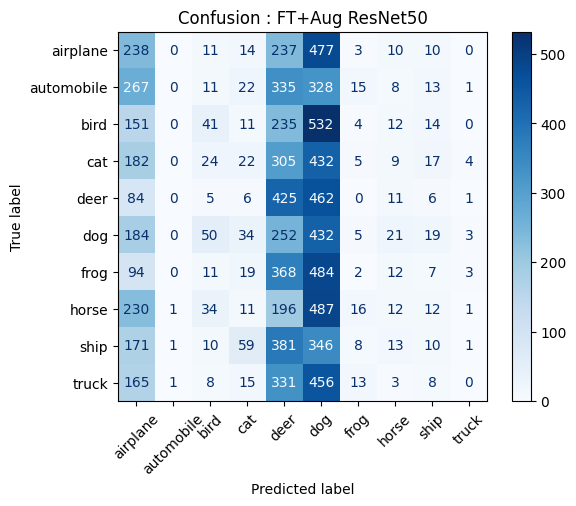

(<Functional name=functional_1, built=True>,
 <keras.src.callbacks.history.History at 0x7f5d9ce948e0>)

In [17]:
set_seed(42)
x_train, y_train_cat, x_test, y_test_cat = load_data()

# Fine-tuning com data augmentation
train_fine_tuning_with_augmentation(
    x_train, y_train_cat,
    x_test,  y_test_cat,
    backbone='ResNet50',
    unfreeze_from=140,
    epochs=30,
    batch_size=64,
    learning_rate=1e-4
)

Epoch 1/30


/home/philipe.hfransozi/Downloads/atividade_3/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 60s - 86ms/step - accuracy: 0.1044 - loss: 2.4042 - val_accuracy: 0.1108 - val_loss: 2.3360
Epoch 2/30
704/704 - 59s - 83ms/step - accuracy: 0.1087 - loss: 2.3517 - val_accuracy: 0.1132 - val_loss: 2.3278
Epoch 3/30
704/704 - 59s - 83ms/step - accuracy: 0.1075 - loss: 2.3363 - val_accuracy: 0.1128 - val_loss: 2.3153
Epoch 4/30
704/704 - 59s - 83ms/step - accuracy: 0.1075 - loss: 2.3294 - val_accuracy: 0.1184 - val_loss: 2.3158
Epoch 5/30
704/704 - 59s - 83ms/step - accuracy: 0.1084 - loss: 2.3264 - val_accuracy: 0.1144 - val_loss: 2.3249
Epoch 6/30
704/704 - 59s - 84ms/step - accuracy: 0.1087 - loss: 2.3221 - val_accuracy: 0.1180 - val_loss: 2.3086
Epoch 7/30
704/704 - 59s - 83ms/step - accuracy: 0.1100 - loss: 2.3179 - val_accuracy: 0.1194 - val_loss: 2.3111
Epoch 8/30
704/704 - 68s - 97ms/step - accuracy: 0.1113 - loss: 2.3167 - val_accuracy: 0.1188 - val_loss: 2.3121
Epoch 9/30
704/704 - 73s - 104ms/step - accuracy: 0.1111 - loss: 2.3157 - val_accuracy: 0.1198 - val_loss: 

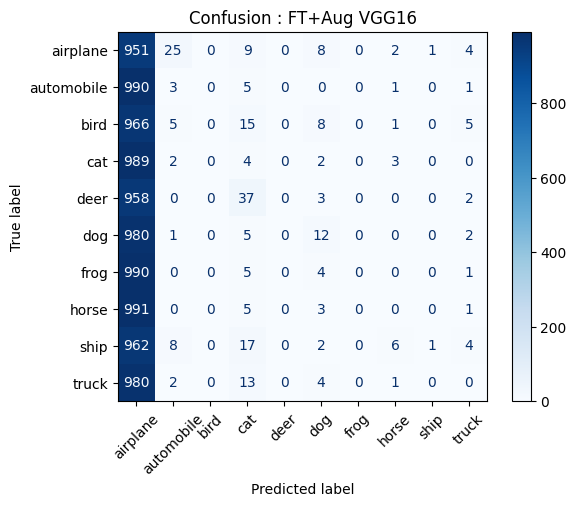

(<Functional name=functional_2, built=True>,
 <keras.src.callbacks.history.History at 0x7f5d9cc50e20>)

In [18]:
set_seed(42)
x_train, y_train_cat, x_test, y_test_cat = load_data()

# Fine-tuning com data augmentation
train_fine_tuning_with_augmentation(
    x_train, y_train_cat,
    x_test,  y_test_cat,
    backbone='VGG16',
    unfreeze_from=140,
    epochs=30,
    batch_size=64,
    learning_rate=1e-4
)